<h2><center> Total Generalised Variation Inpainting </center></h2>

### In this demo, we solve the following minimisation problem:

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \|\mathcal{M}u-g\|_{1} + \mathrm{TGV}_{\alpha, \beta}(u)
\end{equation}$$

where,

* $g$ is a corrupted image with missing pixels, defined by the inpainting domain $\mathcal{D}\setminus\Omega$. 
* $\mathcal{M}$ is a diagonal operator with ones in the diagonal elements corresponding to pixels in $\Omega\setminus\mathcal{D}$ and zeros in $\mathcal{D}$.
* $\mathrm{TGV}_{\alpha, \beta}$ stands for the **Total Generalised Variation** introduced in [Bredies_et_al](https://epubs.siam.org/doi/abs/10.1137/090769521?mobileUi=0) and is defined as

$$\begin{equation}
\mathrm{TGV}_{\alpha, \beta}(u) = \min_{w} \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\end{equation}
$$
where,

* $\alpha$ and $\beta$ are regularising parameters and 
* $\mathcal{E}w = \frac{1}{2}(D w + D w^{T})$ denotes the symmetrized gradient operator.


In [1]:
# Import libraries
from cil.framework import ImageGeometry
from cil.utilities import dataexample, noise
from cil.optimisation.operators import MaskOperator, BlockOperator, SymmetrisedGradientOperator, \
                                GradientOperator, ZeroOperator, IdentityOperator, ChannelwiseOperator
from cil.optimisation.functions import ZeroFunction, L1Norm, MixedL21Norm, BlockFunction
from cil.optimisation.algorithms import PDHG

from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

We first load the _RAINBOW_ image from the dataexample class and create a text inpainted domain using the **Pillow** library.

In [2]:
# Load Rainbow data
data = dataexample.RAINBOW.get(size=(256,256))
data.reorder(['horizontal_y', 'horizontal_x','channel'])
ig = data.geometry
im = data.array

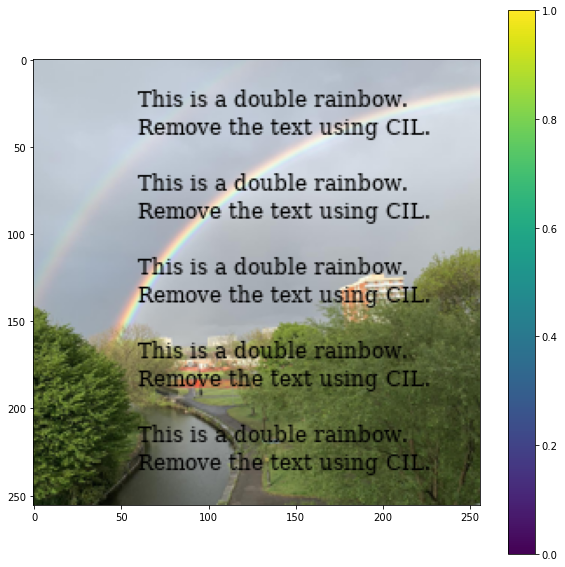

In [3]:
# Create inpainted image using Pillow
data_PIL = Image.fromarray(np.uint8(im*255)).convert('RGB')
text = "\n               This is a double rainbow.\n               Remove the text using CIL. \n"*5
draw = ImageDraw.Draw(data_PIL)
font = ImageFont.truetype('DejaVuSerif.ttf', 12)
draw.text((0, 0), text, (0, 0, 0), font=font)

tmp_np = np.array(data_PIL)
data_np = tmp_np/tmp_np.max()
data_inpainted= ig.allocate()
data_inpainted.fill(data_np)

plt.figure(figsize=(10,10))
plt.imshow(data_inpainted.as_array())
plt.colorbar()
plt.show()

Then, we create a mask array, based on the missing text and applied it to the Red, Green and Blue channels of the coloured image using the **ChannelwiseOperator**. Finally, salt and pepper noise is added to create the `noisy_data`.

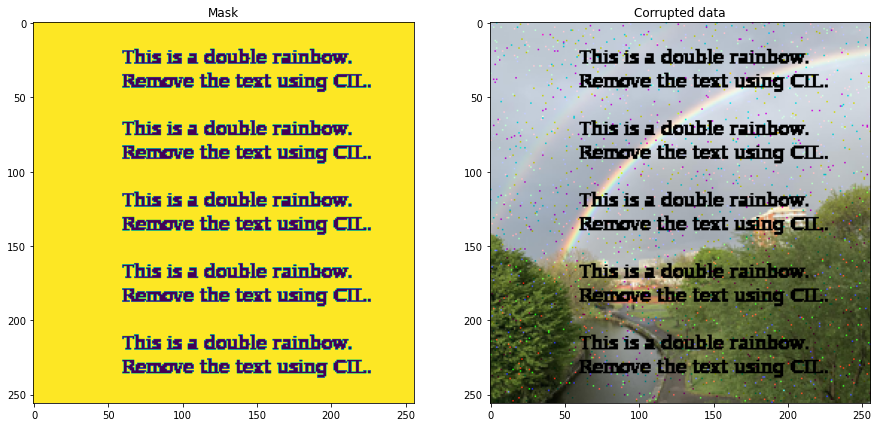

In [4]:
# Create mask from corrupted image and apply MaskOperator channelwise
mask = (data_inpainted - data).abs()
mask_ind = mask.abs()==0

mask2D = mask_ind[:,:,0]
mask = ig.subset(channel=0).allocate(True,dtype=np.bool)
mask.fill(mask2D)

# Define ChannelwiseOperator
MO = ChannelwiseOperator(MaskOperator(mask), 3, dimension = 'append')

# Add salt and pepper noise
noisy_data = noise.saltnpepper(data_inpainted, amount=0.01, seed = 10)
noisy_data = MO.direct(noisy_data) 

f, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(mask.as_array())
ax[0].title.set_text("Mask")

ax[1].imshow(noisy_data.as_array())
ax[1].title.set_text("Corrupted data")

Finally, we setup and run the PDHG algorithm using the Total Generalised variation regularisation. We need to write the minimisation problem:

$$\begin{equation}
    (u^{*},w^{*}) =\underset{u, w}{\operatorname{argmin}} \|\mathcal{M}u -b\|_{1} + \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1}    
\end{equation}$$

in the following general form $$\underset{x}{\operatorname{argmin}} f(Kx) + g(x).$$


Let $x = (u, w)\in \mathbb{X}$ and define an operator $K:\mathbb{X}\rightarrow\mathbb{Y}$ as$\\[10pt]$
$$\begin{equation}
K = 
\begin{bmatrix}
\mathcal{M} & \mathcal{O}\\
D & -\mathcal{I}\\
\mathcal{O} & \mathcal{E}
\end{bmatrix} \quad\Rightarrow\quad
Kx = 
K \begin{bmatrix}
u\\
w
\end{bmatrix}=
\begin{bmatrix}
\mathcal{M}u\\
Du - w\\
\mathcal{E}w
\end{bmatrix} = 
\begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}
\end{bmatrix} = y\in \mathbb{Y},
\label{def_K}
\end{equation}$$

$$\begin{equation}
\begin{aligned}
& f(y)  := f(y_{1}, y_{2}, y_{3}) = f_{1}(y_{1}) +  f_{2}(y_{2})  +  f_{3}(y_{3}), \mbox{ where},\\[10pt]
& f_{1}(y_{1}) :=  \| y_{1} - b\|_1,\, f_{2}(y_{2}) :=  \alpha \|y_{2}\|_{2,1},\, f_{3}(y_{3}) := \beta\|y_{3}\|_{2,1},
\end{aligned}
\label{def_f}
\end{equation}\\[10pt]$$
and $g(x) = g(u,w) = O(u)\equiv 0 $ is the zero function. 

In [ ]:
# Setup PDHG for TGV regularisation
alpha = 0.7
beta = 0.2

# Define BlockFunction f
f1 = L1Norm(b=noisy_data)
f2 = alpha * MixedL21Norm()
f3 = beta * MixedL21Norm() 
f = BlockFunction(f1, f2, f3)         

# Define function g 
g = ZeroFunction()

# Define BlockOperator K
K11 = MO
K21 = GradientOperator(ig)
K32 = SymmetrisedGradientOperator(K21.range)
K12 = ZeroOperator(K32.domain, ig)
K22 = IdentityOperator(K21.range)
K31 = ZeroOperator(ig, K32.range)
K = BlockOperator(K11, K12, K21, -K22, K31, K32, shape=(3,2) )

# Compute operator Norm
normK = K.norm()
sigma = 1.
tau = 1./(sigma*normK**2)

# Setup and run the PDHG algorithm
pdhg = PDHG(f=f,g=g,operator=K,
            max_iteration = 500, sigma=sigma, tau=tau,
            update_objective_interval = 100)
pdhg.run(verbose = 2)      

/home/vaggelis/miniconda3/envs/cil2_demos/lib/python3.8/site-packages/cil/optimisation/operators/GradientOperator.py:84: UserWarning: Warning: correlation='Space' on multi-channel dataset will use `numpy` backend
  warnings.warn("Warning: correlation='Space' on multi-channel dataset will use `numpy` backend")


Initialised GradientOperator with numpy backend
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    1.01472e+05  -0.00000e+00    1.01472e+05


/home/vaggelis/miniconda3/envs/cil2_demos/lib/python3.8/site-packages/cil/framework/framework.py:2173: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.131    4.79956e+03  -1.98989e+03    6.78944e+03


In [ ]:
show_images = [data, noisy_data, pdhg.solution.get_item(0), 
               (pdhg.solution.get_item(0)-data).abs()+0.1]
title_image = ["Ground Truth", "Corrupted Data", "TGV", "Absolute difference"]                   


fig = plt.figure(figsize=(20, 20))
grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.45)

k = 0
for ax in grid:
        
    im = ax.imshow(show_images[k].as_array())
    ax.set_title(title_image[k],fontsize=25)    
    k+=1
    
plt.show()